<a href="https://colab.research.google.com/github/eastman-ki/AI_Camp_Projects/blob/main/ai11_%EA%B8%B0%EB%8F%99%EC%9D%B8_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 출처: https://www.kaggle.com/mlg-ulb/creditcardfraud
# 금융사기탐지 모델 구현하기

### eli5와, shap, pdpbox 설치하는 부분입니다.

In [ ]:
pip install eli5

In [ ]:
pip install shap

In [ ]:
pip install PDPbox

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, RobustScaler
import shap
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
from google.colab import files
myfile = files.upload()

Saving creditcard.csv to creditcard.csv


# Step 1. 데이터를 변환하기

## 1. 데이터 확인하기

In [ ]:
# 파일 불러오기
df = pd.read_csv(io.BytesIO(myfile['creditcard.csv']))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 로드한 데이터의 맨 윗 30개 행 확인하기
df.head(30)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
# Missing 여부 확인하기
df.isnull().sum().sum()

0

Missing 없음!!

In [ ]:
# 불러온 데이터의 클래스 분포 확인하기
df.groupby(by=['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


클래스가 0과 1로 나누어진 것으로 볼 때 분류모델로 처리하는 것이 옳다고 본다.

Class
0    284315
1       492
Name: Class, dtype: int64
Target class is  0.1727 %


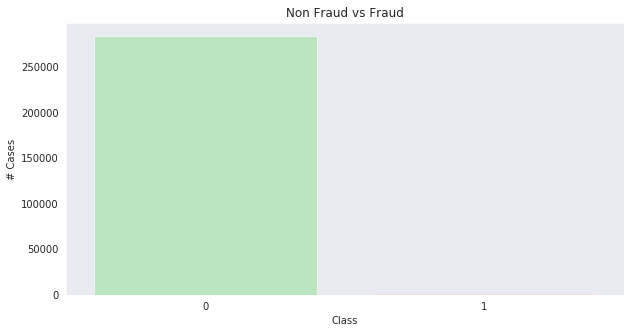

In [ ]:
print(df.groupby(['Class']).Class.count())
print('Target class is ', '{0:0.4f}'. format(492/(284315+492)*100), '%')
sns.set_style('dark')
plt.figure(figsize = (10,5))
sns.countplot(df['Class'], 
              alpha =.60, 
              palette= ['lightgreen','red']);
plt.title('Non Fraud vs Fraud');
plt.ylabel('# Cases')
plt.show()

Non-Fraud와 Fraud의 차이가 매우 큼. 불균형이다.

#### Correlation

In [ ]:
X = df.drop('Class', axis = 1)
y = df['Class']
cols = X.columns.tolist()

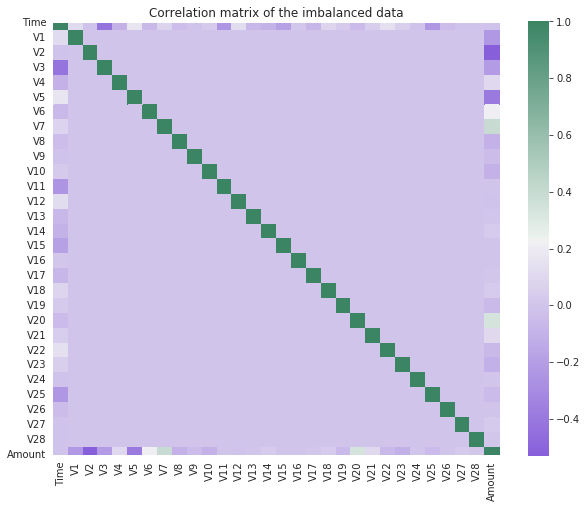

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = X.corr();
sns.heatmap(corr, 
            mask = np.zeros_like(corr, 
                                 dtype=np.bool), 
            cmap = sns.diverging_palette(275, 
                                         150, 
                                         as_cmap=True), 
            square = True, 
            ax = ax);
plt.title('Correlation matrix of the imbalanced data');

뚜렷한 상관관계도 보이지 않는다.

## 2. 변수의 스케일 변환하기

In [ ]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler() ## 

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 원 데이터에서 Time 컬럼과 Amount 컬럼 제외하기
df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
# 스케일 조정된 컬럼 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

## 스케일 조정된 데이터 확인하기

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 3. 샘플 데이터 나누기

In [ ]:
# X와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 데이터 나누기
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

In [ ]:
# 클래스의 skew 정도가 매우 높기 때문에 클래스간 분포를 맞추는 것이 필요합니다.
# subsample 구축 전 셔플링을 통해 레이블이 한쪽에 몰려있지 않도록 하겠습니다.

df = df.sample(frac=1)

# 데이터 준비
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 데이터 셔플하기
new_df = normal_distributed_df.sample(frac=1, random_state=0)

# 셔플한 새로운 데이터 셋 확인
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
68522,-0.296793,-0.371962,0.206075,1.387360,-1.045287,4.228686,-1.647549,-0.180897,-2.943678,0.859156,...,0.351484,0.469199,0.344930,-0.203799,0.376640,0.715485,0.226003,0.628545,0.319918,1
60447,-0.274576,-0.415501,-1.323322,1.521562,1.227769,-0.538306,0.616795,-0.351622,1.341915,-0.909075,...,0.410711,-0.015999,0.507969,-0.302493,0.031908,-0.303688,0.097853,-1.467227,-0.938245,0
154693,-0.293440,0.210611,-2.488363,4.359019,-7.776410,5.364027,-1.823877,-2.445140,-4.964221,1.484890,...,0.792275,1.325672,1.021226,-0.266476,-0.370880,0.365535,0.081372,0.184983,-0.211582,1
114345,-0.279746,-0.132168,1.235800,0.261674,0.179705,0.504923,-0.194219,-0.571141,-0.053582,-0.010103,...,-0.087561,-0.262564,-0.814985,0.081571,-0.049279,0.214459,0.098805,-0.030309,0.016380,0
26752,-0.097813,-0.592805,1.022332,-0.431597,1.717492,1.842019,-1.328039,0.630142,-1.003991,0.459343,...,-0.291148,-0.147804,0.017915,0.031946,0.390178,0.374026,-0.308437,0.105381,0.034553,0


# Step 2. Random Undersampling 으로 샘플 재구축하기

## 1. 재구축 샘플로 분류모델 구현하기

In [ ]:
# 재구축한 데이터의 클래스 분포 확인하기
new_df.groupby(by=['Class']).count()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
Class,,,,,,,,,,,,,,,,,,,,,
0,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


In [ ]:
# X와 y 데이터 셋 만들기
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [ ]:
# 언더샘플링을 위한 샘플 데이터 구축
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# 훈련용, 검증용, 테스트용으로 나눠서 만들고 싶었으나 
# Non-Fraud와 Fraud의 숫자가 불균형해서 그냥 훈련용과 테스트용으로 나눔.

In [ ]:
# 모델 인풋에 들어가기 위한 데이터의 형태 바꾸기
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBM Classifier": XGBClassifier()
}

In [ ]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LogisticRegression : 94.0 % accuracy
DecisionTreeClassifier : 89.0 % accuracy
RandomForestClassifier : 94.0 % accuracy
XGBClassifier : 94.0 % accuracy


## 2. 분류 결과 확인하기

In [ ]:
# 모델별 분류결과 확인하기
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test) ####
    results = classification_report(y_test, y_pred) ####
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       101
           1       0.98      0.94      0.96        96

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197

DecisionTreeClassifier ------- 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       101
           1       0.94      0.94      0.94        96

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

RandomForestClassifier ------- 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       101
           1       0.97      0.94      0.95        96

    accuracy                           0.95       197
   macro avg       0.96      0.95

In [ ]:
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test) ####
    cm = confusion_matrix(y_test, y_pred) ####
    print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
 [[99  2]
 [ 6 90]] 

DecisionTreeClassifier 
 [[95  6]
 [ 6 90]] 

RandomForestClassifier 
 [[98  3]
 [ 6 90]] 

XGBClassifier 
 [[98  3]
 [ 6 90]] 



# Step 3. SMOTE 로 Oversampling 하기 
불균형인 Non-Fraud와 Fraud의 관계를 극복하기 위한 방법!! \
리샘플링(SMOTE: Synthetic Minority Oversampling Technique)의 약자

## 1. SMOTE로 Oversampling하기

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(original_Xtrain,list(original_ytrain)) ####
bal_data = pd.DataFrame(X_resampled)
bal_data.columns

print('Before SMOTE, original X_train: {}'.format(original_Xtrain.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(original_ytrain).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(original_ytrain)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(original_ytrain)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (227846, 30)
Before SMOTE, original y_train: (227846,)
After  SMOTE, resampled original X_train: (454904, 30)
After  SMOTE, resampled original y_train: (454904,) 

Before SMOTE,     fraud counts: 394
Before SMOTE, non-fraud counts: 227452
After  SMOTE,     fraud counts: 227452
After  SMOTE, non-fraud counts: 227452


In [ ]:
227452+394

227846

In [ ]:
cols = X_resampled.columns

Class
0    227452
1    227452
Name: Class, dtype: int64


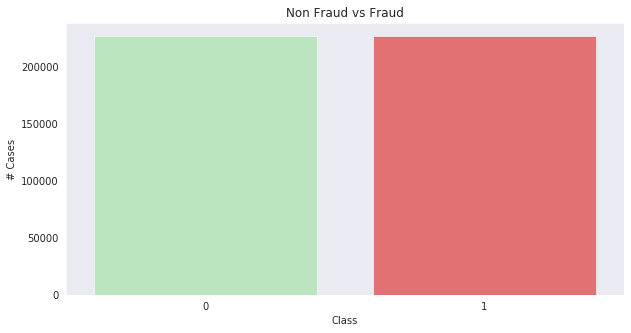

In [ ]:
bal_data = pd.DataFrame(X_resampled)
bal_data.columns = cols
bal_data['Class'] = y_resampled
print(bal_data.groupby(['Class']).Class.count())
sns.set_style('dark')
plt.figure(figsize = (10,5))
sns.countplot(bal_data['Class'], 
              alpha =.60, 
              palette= ['lightgreen','red'])
plt.title('Non Fraud vs Fraud')
plt.ylabel('# Cases')
plt.show()

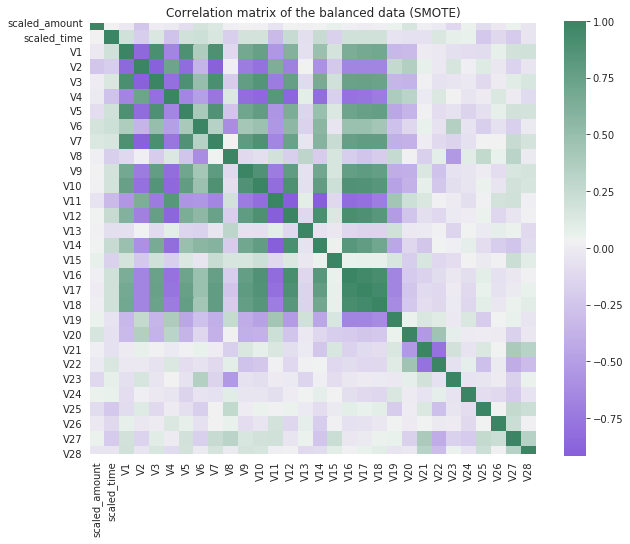

In [ ]:
bal_data = bal_data.drop('Class', axis = 1)
fig, ax = plt.subplots(figsize=(10, 8))
corr = bal_data.corr();
sns.heatmap(corr, 
            mask = np.zeros_like(corr, 
                                 dtype=np.bool), 
            cmap = sns.diverging_palette(275, 
                                         150, 
                                         as_cmap=True), 
            square = True, 
            ax = ax);
plt.title('Correlation matrix of the balanced data (SMOTE)');

#### 상관관계가 더 뚜렷하게 보인다.

## 2. 재구축한 샘플로 분류 모형 구현하기

In [ ]:
X_resampled = X_resampled.drop(["Class"], axis = 1)
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454904 entries, 0 to 454903
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   scaled_amount  454904 non-null  float64
 1   scaled_time    454904 non-null  float64
 2   V1             454904 non-null  float64
 3   V2             454904 non-null  float64
 4   V3             454904 non-null  float64
 5   V4             454904 non-null  float64
 6   V5             454904 non-null  float64
 7   V6             454904 non-null  float64
 8   V7             454904 non-null  float64
 9   V8             454904 non-null  float64
 10  V9             454904 non-null  float64
 11  V10            454904 non-null  float64
 12  V11            454904 non-null  float64
 13  V12            454904 non-null  float64
 14  V13            454904 non-null  float64
 15  V14            454904 non-null  float64
 16  V15            454904 non-null  float64
 17  V16            454904 non-nul

In [ ]:
# 재구축한 샘플 데이터로 모델 피팅하기

logreg_resampled = LogisticRegression(random_state=0) ###
logreg_resampled.fit(X_resampled, y_resampled) ###

# 예측값 구하기
y_pred = logreg_resampled.predict(original_Xtest)

print('Logistic Regression ------ Resampled Data')
print(f'Accuracy: {accuracy_score(original_ytest,y_pred)}') ###
print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred)}') ###
print('\n')
print(f'Recall: {recall_score(original_ytest,y_pred)}') ###

Logistic Regression ------ Resampled Data
Accuracy: 0.9884482365127016


Confusion Matrix: 
[[56218   645]
 [   13    85]]


Recall: 0.8673469387755102


In [ ]:
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(original_ytest, y_pred, target_names=label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      0.99      0.87      0.99      0.93      0.87     56863
      fraud       0.12      0.87      0.99      0.21      0.93      0.85        98

avg / total       1.00      0.99      0.87      0.99      0.93      0.87     56961



# Step 4. Feature selection

## 1. Feature Importance

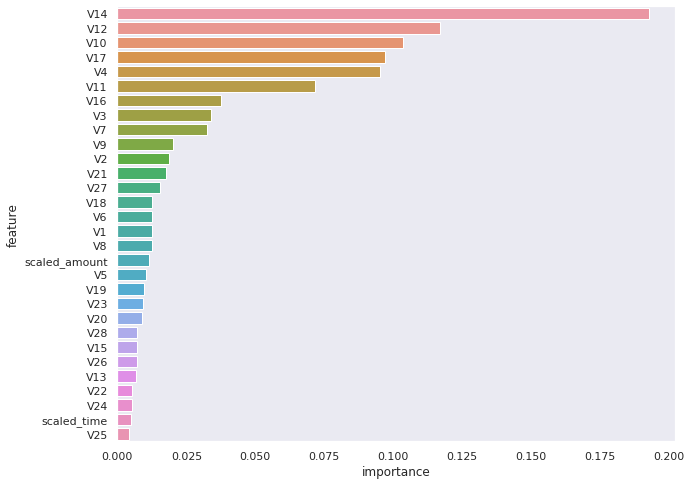

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
rf = RandomForestClassifier(n_jobs = -1, 
                            random_state = 101)
rf.fit(X_train_res, y_train_res)
feat_imp = rf.feature_importances_
sns.set(style="dark")
fig, ax = plt.subplots(figsize=(10, 8))
var_imp = pd.DataFrame({'feature':cols, 
                        'importance':feat_imp})
var_imp = var_imp.sort_values(ascending=False, 
                              by='importance')
ax = sns.barplot(x='importance', 
                 y='feature', 
                 data=var_imp)

In [ ]:
var_imp['feature_imp_cumsum'] = var_imp['importance'].cumsum()
var_imp

,feature,importance,feature_imp_cumsum
15,V14,0.178856,0.178856
13,V12,0.127488,0.306344
5,V4,0.105165,0.411508
18,V17,0.093617,0.505125
11,V10,0.093480,0.598605
12,V11,0.056268,0.654873
8,V7,0.047178,0.702051
17,V16,0.040024,0.742075
4,V3,0.032137,0.774212
22,V21,0.025731,0.799943


In [ ]:
top_features = SelectFromModel(rf, threshold=0.01)
top_features.fit(X_train_res, y_train_res)
rf_features= X_train.columns[(top_features.get_support())]
rf_features = rf_features.tolist()
rf_features

['scaled_amount',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V21',
 'V27']

## 2. 순열 중요도(Permutation Importance)

In [ ]:
perm = PermutationImportance(rf.fit(X_train_res, 
                                    y_train_res), 
                             random_state=1).fit(X_train_res,
                                                 y_train_res)
eli5.show_weights(perm, 
                  feature_names = X_train.columns.tolist(), 
                  top=(30))

Weight,Feature
0.0710 ± 0.0173,V14
0.0105 ± 0.0069,V4
0.0048 ± 0.0023,V10
0.0043 ± 0.0025,V12
0.0037 ± 0.0014,V23
0.0026 ± 0.0021,scaled_amount
0.0020 ± 0.0014,V8
0.0014 ± 0.0000,V13
0.0014 ± 0.0000,V25
0.0011 ± 0.0011,V15


#. 

In [ ]:
X_train.columns

Index(['scaled_amount', 'scaled_time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28'],
      dtype='object')

In [ ]:
pi_features = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.001]['feature'].tolist()

In [ ]:
print("\nFeatures from feature importance", rf_features)
print("\nFeatures from permutation importance", pi_features)


Features from feature importance ['scaled_amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V21', 'V27']

Features from permutation importance ['V14', 'V4', 'V10', 'V12', 'V23', 'scaled_amount', 'V8', 'V13', 'V25', 'V15', 'V27', 'V17']


## 1. Logistic Regression

### 1) Baseline(All Features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
lreg = LogisticRegression()
lreg_model_all = lreg.fit(X_train_res, y_train_res)
y_pred_lreg_all = lreg_model_all.predict(X_test)

print('Confusion Matrix')
print('__'*10)
print(confusion_matrix(y_test, 
                       y_pred_lreg_all))
print('__'*30)
print('\nClassification Metrics')
print('__'*30)
print(classification_report(y_test, 
                            y_pred_lreg_all))
print('__'*30)
logreg_accuracy = round(accuracy_score(y_test, 
                                       y_pred_lreg_all) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Confusion Matrix
____________________
[[162   1]
 [  6 127]]
____________________________________________________________

Classification Metrics
____________________________________________________________
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       163
           1       0.99      0.95      0.97       133

    accuracy                           0.98       296
   macro avg       0.98      0.97      0.98       296
weighted avg       0.98      0.98      0.98       296

____________________________________________________________
Accuracy 97.64 %


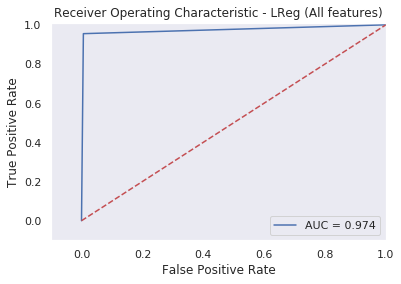

In [ ]:
fpr_lreg_all, tpr_lreg_all, thresholds = roc_curve(y_test, 
                                                   y_pred_lreg_all)
roc_auc_lreg_all = auc(fpr_lreg_all,
                       tpr_lreg_all)
plt.title('Receiver Operating Characteristic - LReg (All features)')
plt.plot(fpr_lreg_all, 
         tpr_lreg_all, 
         'b',
         label='AUC = %0.3f'% roc_auc_lreg_all)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2) RF feature selection

In [ ]:
X_rf = X[rf_features]
X_train, X_test, y_train, y_test = train_test_split(X_rf,
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
lreg = LogisticRegression()
lreg_model_rf = lreg.fit(X_train_res, y_train_res)
y_pred_lreg_rf = lreg_model_rf.predict(X_test)

print('Confusion Matrix')
print('__'*10)
print(confusion_matrix(y_test, 
                       y_pred_lreg_rf))
print('__'*30)
print('\nClassification Metrics')
print('__'*30)
print(classification_report(y_test, 
                            y_pred_lreg_rf))
print('__'*30)
logreg_accuracy = round(accuracy_score(y_test, 
                                       y_pred_lreg_rf) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Confusion Matrix
____________________
[[162   1]
 [  5 128]]
____________________________________________________________

Classification Metrics
____________________________________________________________
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       163
           1       0.99      0.96      0.98       133

    accuracy                           0.98       296
   macro avg       0.98      0.98      0.98       296
weighted avg       0.98      0.98      0.98       296

____________________________________________________________
Accuracy 97.97 %


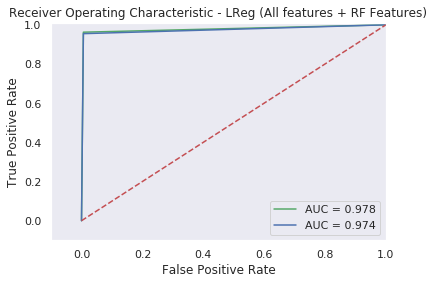

In [ ]:
fpr_lreg_rf, tpr_lreg_rf, thresholds_rf = roc_curve(y_test, 
                                                   y_pred_lreg_rf)
roc_auc_lreg_rf = auc(fpr_lreg_rf,
                       tpr_lreg_rf)
plt.title('Receiver Operating Characteristic - LReg (All features + RF Features)')
plt.plot(fpr_lreg_rf, 
         tpr_lreg_rf, 
         'g',
         label='AUC = %0.3f'% roc_auc_lreg_rf)
plt.plot(fpr_lreg_all, 
         tpr_lreg_all, 
         'b',
         label='AUC = %0.3f'% roc_auc_lreg_all)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3) PI feature selection

In [ ]:
X_pf = X[pi_features]
X_train, X_test, y_train, y_test = train_test_split(X_pf, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
lreg_model_pi = lreg.fit(X_train_res, y_train_res)
y_pred_lreg_pi = lreg_model_pi.predict(X_test)

print('Confusion Matrix')
print('__'*10)
print(confusion_matrix(y_test, 
                       y_pred_lreg_pi))
print('__'*30)
print('\nClassification Metrics')
print('__'*30)
print(classification_report(y_test, 
                            y_pred_lreg_pi))
print('__'*30)
logreg_accuracy = round(accuracy_score(y_test, 
                                       y_pred_lreg_pi) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Confusion Matrix
____________________
[[159   4]
 [  5 128]]
____________________________________________________________

Classification Metrics
____________________________________________________________
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       163
           1       0.97      0.96      0.97       133

    accuracy                           0.97       296
   macro avg       0.97      0.97      0.97       296
weighted avg       0.97      0.97      0.97       296

____________________________________________________________
Accuracy 96.96 %


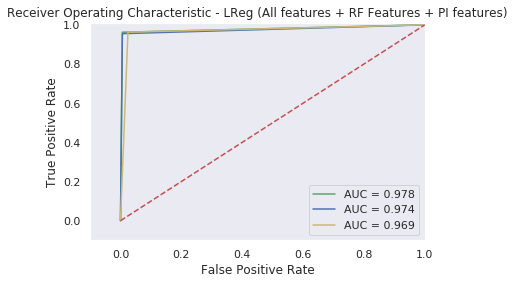

In [ ]:
fpr_lreg_pi, tpr_lreg_pi, thresholds_pi = roc_curve(y_test, 
                                                   y_pred_lreg_pi)
roc_auc_lreg_pi = auc(fpr_lreg_pi,
                       tpr_lreg_pi)
plt.title('Receiver Operating Characteristic - LReg (All features + RF Features + PI features)')
plt.plot(fpr_lreg_rf, 
         tpr_lreg_rf, 
         'g',
         label='AUC = %0.3f'% roc_auc_lreg_rf)
plt.plot(fpr_lreg_all, 
         tpr_lreg_all, 
         'b',
         label='AUC = %0.3f'% roc_auc_lreg_all)
plt.plot(fpr_lreg_pi, 
         tpr_lreg_pi, 
         'y',
         label='AUC = %0.3f'% roc_auc_lreg_pi)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2. Random Forest

### 1) All Features

In [ ]:
rf_model_all = rf.fit(X_train_res, y_train_res)
y_pred_rf_all = rf_model_all.predict(X_test.values)

print('Confusion Matrix')
print('__'*10)
print(confusion_matrix(y_test, 
                       y_pred_rf_all))
print('__'*30)
print('\nClassification Metrics')
print('__'*30)
print(classification_report(y_test, 
                            y_pred_rf_all))
print('__'*30)
logreg_accuracy = round(accuracy_score(y_test, 
                                       y_pred_rf_all) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Confusion Matrix
____________________
[[160   3]
 [  7 126]]
____________________________________________________________

Classification Metrics
____________________________________________________________
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       163
           1       0.98      0.95      0.96       133

    accuracy                           0.97       296
   macro avg       0.97      0.96      0.97       296
weighted avg       0.97      0.97      0.97       296

____________________________________________________________
Accuracy 96.62 %


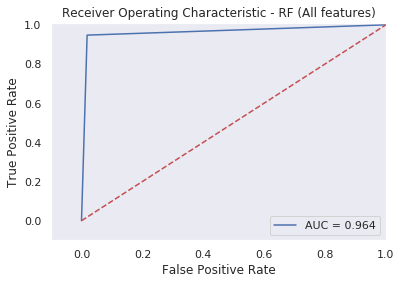

In [ ]:
fpr_rf_all, tpr_rf_all, thresholds = roc_curve(y_test, 
                                                   y_pred_rf_all)
roc_auc_rf_all = auc(fpr_rf_all,
                       tpr_rf_all)
plt.title('Receiver Operating Characteristic - RF (All features)')
plt.plot(fpr_rf_all, 
         tpr_rf_all, 
         'b',
         label='AUC = %0.3f'% roc_auc_rf_all)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 2) RF feature selection

In [ ]:
X_rf = X[rf_features]
X_train, X_test, y_train, y_test = train_test_split(X_rf, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
rf_model_rf = rf.fit(X_train_res, y_train_res)
y_pred_rf_rf = rf_model_rf.predict(X_test.values)

print('Confusion Matrix')
print('__'*10)
print(confusion_matrix(y_test, 
                       y_pred_rf_rf))
print('__'*30)
print('\nClassification Metrics')
print('__'*30)
print(classification_report(y_test, 
                            y_pred_rf_rf))
print('__'*30)
logreg_accuracy = round(accuracy_score(y_test, 
                                       y_pred_rf_rf) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Confusion Matrix
____________________
[[159   4]
 [  6 127]]
____________________________________________________________

Classification Metrics
____________________________________________________________
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       163
           1       0.97      0.95      0.96       133

    accuracy                           0.97       296
   macro avg       0.97      0.97      0.97       296
weighted avg       0.97      0.97      0.97       296

____________________________________________________________
Accuracy 96.62 %


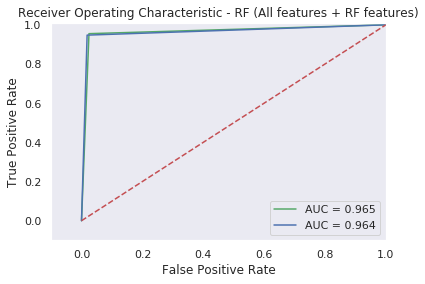

In [ ]:
fpr_rf_rf, tpr_rf_rf, thresholds_rf = roc_curve(y_test, 
                                                   y_pred_rf_rf)
roc_auc_rf_rf = auc(fpr_rf_rf,
                       tpr_rf_rf)
plt.title('Receiver Operating Characteristic - RF (All features + RF features)')
plt.plot(fpr_rf_rf, 
         tpr_rf_rf, 
         'g',
         label='AUC = %0.3f'% roc_auc_rf_rf)
plt.plot(fpr_rf_all, 
         tpr_rf_all, 
         'b',
         label='AUC = %0.3f'% roc_auc_rf_all)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3) PI feature selection

In [ ]:
X_pf = X[pi_features]
X_train, X_test, y_train, y_test = train_test_split(X_pf, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
rf_model_pi = rf.fit(X_train_res, y_train_res)
y_pred_rf_pi = rf_model_pi.predict(X_test.values)

print('Confusion Matrix')
print('__'*10)
print(confusion_matrix(y_test, 
                       y_pred_rf_pi))
print('__'*30)
print('\nClassification Metrics')
print('__'*30)
print(classification_report(y_test, 
                            y_pred_rf_pi))
print('__'*30)
logreg_accuracy = round(accuracy_score(y_test, 
                                       y_pred_rf_pi) * 100,2)
print('Accuracy', logreg_accuracy,'%')

Confusion Matrix
____________________
[[159   4]
 [  9 124]]
____________________________________________________________

Classification Metrics
____________________________________________________________
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       163
           1       0.97      0.93      0.95       133

    accuracy                           0.96       296
   macro avg       0.96      0.95      0.96       296
weighted avg       0.96      0.96      0.96       296

____________________________________________________________
Accuracy 95.61 %


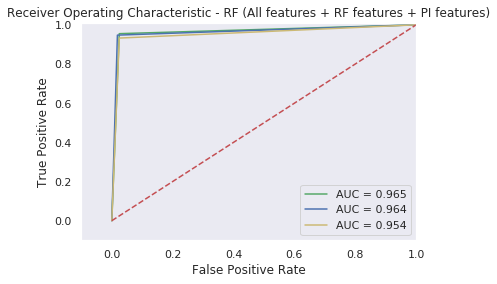

In [ ]:
fpr_rf_pi, tpr_rf_pi, thresholds_pi = roc_curve(y_test, 
                                                   y_pred_rf_pi)
roc_auc_rf_pi = auc(fpr_rf_pi,
                       tpr_rf_pi)
plt.title('Receiver Operating Characteristic - RF (All features + RF features + PI features)')
plt.plot(fpr_rf_rf, 
         tpr_rf_rf, 
         'g',
         label='AUC = %0.3f'% roc_auc_rf_rf)
plt.plot(fpr_rf_all, 
         tpr_rf_all, 
         'b',
         label='AUC = %0.3f'% roc_auc_rf_all)
plt.plot(fpr_rf_pi, 
         tpr_rf_pi, 
         'y',
         label='AUC = %0.3f'% roc_auc_rf_pi)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic Regressor의 All features가 AUC 면적이 더 넓게 나왔다.
반면 정확도에서는 Random Forest의 RF features가 더 높게 나왔다.


# Step 5. ML Model 해석하기

## 1. 부분의존도(Partial Depnendence Plots, PDP)

### 1) V14

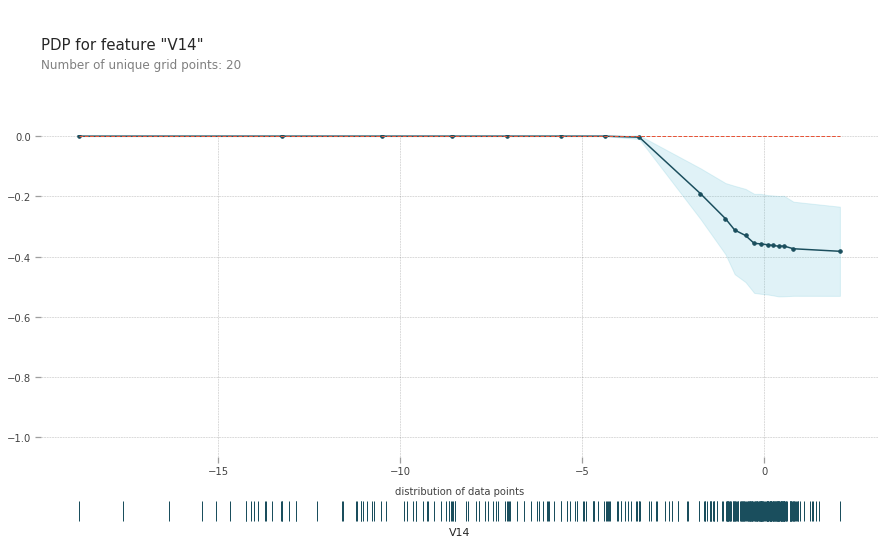

In [ ]:
pdp_V14 = pdp.pdp_isolate(model = rf_model_pi,
                         dataset = X_test, 
                         model_features = pi_features, 
                         feature='V14', 
                         num_grid_points = 20);

pdp.pdp_plot(pdp_V14, 
             'V14', 
             plot_pts_dist=True);
plt.show();

### 2) V4

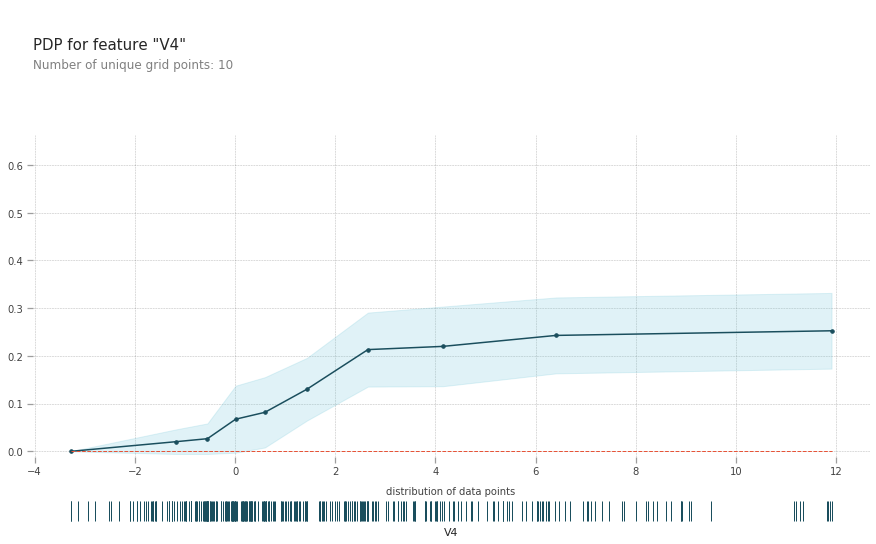

In [ ]:
pdp_V4 = pdp.pdp_isolate(model = rf_model_pi,
                         dataset = X_test, 
                         model_features = pi_features, 
                         feature='V4', 
                         num_grid_points = 10);

pdp.pdp_plot(pdp_V4, 
             'V4', 
             plot_pts_dist=True);
plt.show();

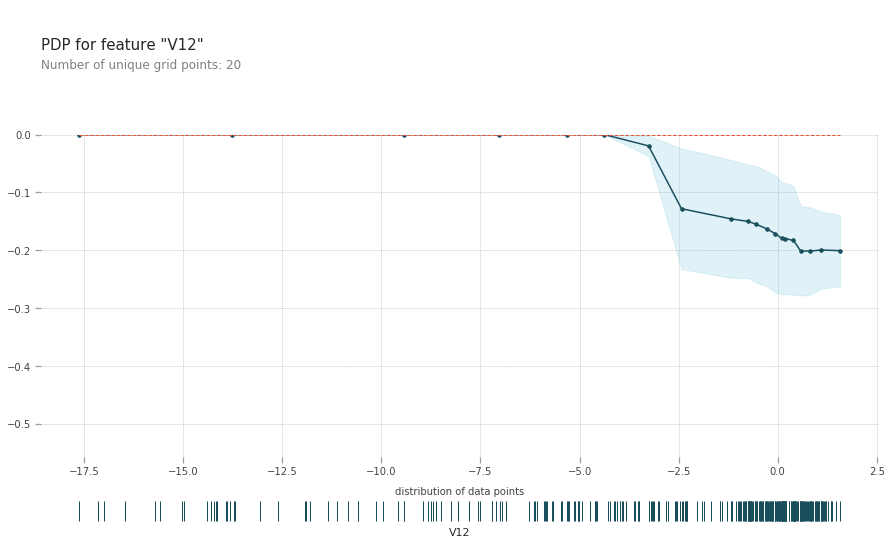

In [ ]:
pdp_V12 = pdp.pdp_isolate(model = rf_model_pi,
                         dataset = X_test, 
                         model_features = pi_features, 
                         feature='V12', 
                         num_grid_points = 20);

pdp.pdp_plot(pdp_V12, 
             'V12', 
             plot_pts_dist=True);
plt.show();

## 2. SHAP

### 1) Explaining predictions

In [ ]:
explainer = shap.TreeExplainer(rf_model_pi)

In [ ]:
data_row = 250
data_row = X_test.iloc[data_row]

shap_values = explainer.shap_values(data_row)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_row)

In [ ]:
data_row = 51
data_row = X_test.iloc[data_row]

shap_values = explainer.shap_values(data_row)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_row)

In [ ]:
data_row = 24
data_row = X_test.iloc[data_row]

shap_values = explainer.shap_values(data_row)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_row)

### 2) SHAP 요약

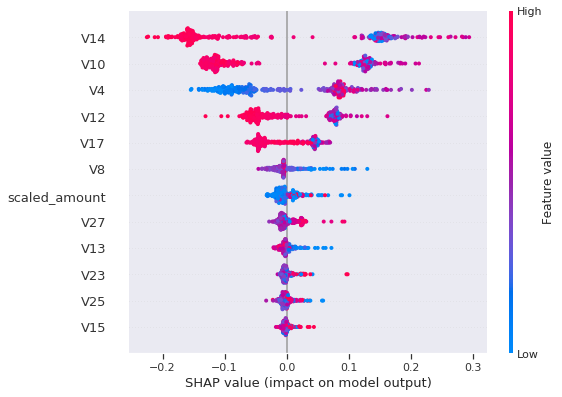

In [ ]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

### 3) SHAP 의존도

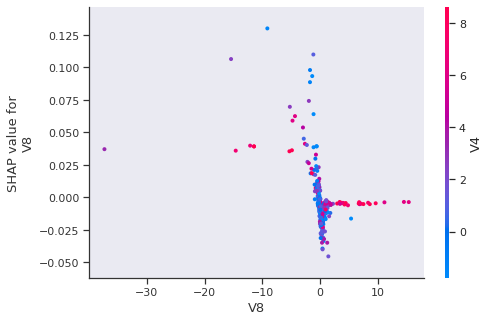

In [ ]:
shap.dependence_plot('V8', shap_values[1], X_test, interaction_index = 'V4')